In [4]:
from brian2 import *

Have pre-synaptic neuron $A$ and postsynaptic neuron $B$. Whenever one of them spikes, the weight between them is updated based on a function of the time distance between the time of this spike, and the spike times that have already occured in the other neuron

$\dot{W} = \dot{W}^A + \dot{W}^B$

$\dot{W}^A = \sum_i \sum_j \delta(t - t^A_i) \Theta(t - t^B_j) f_{STDP}(\Delta t^{AB}_{ij}) $

$\dot{W}^B = \sum_i \sum_j \delta(t - t^B_i) \Theta(t - t^A_j) f_{STDP}(\Delta t^{AB}_{ij}) $

where $\Delta t^{AB}_{ij} = t^A_i - t^B_j$. In the simplest case

$f_{STDP}(\Delta t) = 
A_{\mathrm{forw}}\Theta(\Delta t) e^{-\frac{\Delta t}{\tau_\mathrm{forw}}} -
A_{\mathrm{back}}\Theta(-\Delta t) e^{\frac{\Delta t}{\tau_\mathrm{back}}}$

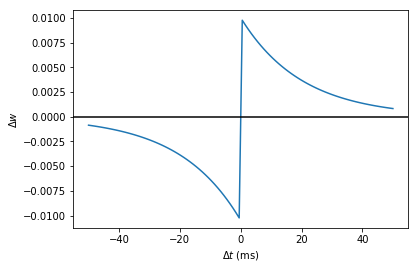

In [16]:
# Plot Hebbian STDP
DW_FORW_TAU = 20*ms
DW_FORW_MAG = 0.01
DW_BACK_TAU = 20*ms
DW_BACK_MAG = -A_pre*1.05

fSTDP = lambda dt : where(dt>0, DW_FORW_MAG*exp(-dt/DW_FORW_TAU), DW_BACK_MAG*exp(dt/DW_BACK_TAU))

dt = linspace(-50, 50, 100)*ms
dw = fSTDP(dt)

plot(dt/ms, dw)
xlabel(r'$\Delta t$ (ms)')
ylabel('$\Delta w$')
axhline(0, ls='-', c='k');

To compute the weight change, we need to keep track how much time has passed since every spike that has occured. For exponential decay-based weight updates, one decaying variable is enough to remember the composite effect.

<table>
    <tr>
        <td> $S^A(t) = \sum_i \delta(t - t^A_i)$ </td>
        <td> Exact spike times in neuron A </td>
    </tr>
    <tr>
        <td> $S^B(t) = \sum_i \delta(t - t^B_i)$ </td>
        <td> Exact spike times in neuron B </td>
    </tr>
    <tr>
        <td> $\dot{z}^A(t) = -\frac{z^A(t)}{\tau^{WA}} + S^{A}(t)$ </td>
        <td> Decaying trace of spike times in neuron A </td>
    </tr>
    <tr>
        <td> $\dot{z}^B(t) = -\frac{z^B(t)}{\tau^{WB}} + S^{B}(t)$ </td>
        <td> Decaying trace of spike times in neuron B </td>
    </tr>
</table>

Then the weight change can be written as

<table><tr><td>
  $\dot{W}(t) = A_{\mathrm{forw}} z^A(t) S^B(t) - A_{\mathrm{back}} z^B(t) S^A(t)$
</td></tr></table>

In *Brian2*, an event *on_pre* is thrown for a presynaptic spike, and *on_post* for a postsynbaptic spike. Thus it remain to add or subtract the decaying variable from the other side of the synapse

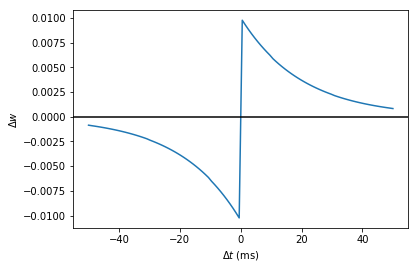

In [23]:
start_scope()

Z_PRE_TAU = 20*ms
Z_PRE_MAG = 0.01
Z_POST_TAU = 20*ms
Z_POST_MAG = -A_pre*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

# For each synapse have two decaying variables
# responding to presynaptic and postsynaptic spikes
syn_eq = '''
w : 1
dzpre/dt = -zpre/Z_PRE_TAU : 1 (event-driven)
dzpost/dt = -zpost/Z_POST_TAU : 1 (event-driven)
'''

# On spike increase decaying variable by fixed amount
# Increase weight by the value of the decaying variable
# from the other side of the synapse
syn_pre_eq = '''
zpre += Z_PRE_MAG
w = w + zpost
'''

syn_post_eq = '''
zpost += Z_POST_MAG
w = w + zpre
'''

S = Synapses(G, H, syn_eq, on_pre=syn_pre_eq, on_post=syn_post_eq)
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');